<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/progressive_resizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training using progressive resizing

Quote from Fastbook:
> jargon: progressive resizing: Gradually using larger and larger images as you train.

Progressive resizing is a very effective technique to train model from scratch or using transfer learning. IceVision now offers a good support for that technique.

For more information about the progressive resizing technique, please check out the reference, here below:

Fastai Fastbook Chapter: https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb

Check out the section: **Progressive Resizing**

## Paper highlighting the importance of progressive resizing:

- [Rethinking Training from Scratch for
Object Detection](https://arxiv.org/pdf/2106.03112v1.pdf)


- [EfficientNetV2: Smaller Models and Faster Training](https://arxiv.org/pdf/2104.00298.pdf)

## Introduction

This tutorial walk you through the different steps of training the fridge dataset using the progressive resizing technique. 

The main differences with IceVision standard training are the use of:

* The `get_dataloaders()` method
```python
# DataLoaders
ds, dls = get_dataloaders(model_type, [train_records, valid_records], [train_tfms, valid_tfms], batch_size=16, num_workers=2)
```

* replacing dataloaders (corresponding to different image sizes) in either a Fastai `Learner` object or a Pytorch-Lightning `Trainer` object as follow:

- For Fastai:

```python
# Replace current dataloaders by the new ones (corresponding to the new size)
learn.dls = fastai_dls

# Standard training
learn.lr_find()
learn.fine_tune(10, 1e-4, freeze_epochs=1)
```

- Pytorch-Lightning:

```python
# Replace current dataloaders by the new ones (corresponding to the new size)
trainer.train_dataloader = dls[0]
trainer.valid_dataloader = dls[1]

# Standard training
trainer.fit(light_model, dls[0], dls[1])
```


## Installing IceVision and IceData

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

In [ ]:
# Restart kernel after installation
exit()

## Imports

In [ ]:
from icevision.all import *

In [2]:
from fastai.callback.tracker import SaveModelCallback

## Datasets : Fridge Objects dataset
Fridge Objects dataset is tiny dataset that contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides very handy methods such as loading a dataset, parsing annotations, and more. 

In [ ]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

In [4]:
# Parser
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "odFridgeObjects/annotations", images_dir=data_dir / "odFridgeObjects/images")


In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

## Creating a model

In [ ]:
# Just change the value of selection to try another model

selection = 0


extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

## Train and Validation Dataset Transforms

## Initial size: First size (size = 384)

In [8]:
# Transforms
presize = 512
size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

In [9]:
# DataLoaders
ds, dls = get_dataloaders(model_type, [train_records, valid_records], [train_tfms, valid_tfms], batch_size=16, num_workers=2)

In [10]:
# dls[0].dataset[0]
ds[0][0]

BaseRecord

common: 
	- Image size ImgSize(width=384, height=384)
	- Filepath: /root/.icevision/data/fridge/odFridgeObjects/images/112.jpg
	- Img: 384x384x3 <np.ndarray> Image
	- Record ID: 15
detection: 
	- BBoxes: [<BBox (xmin:131.17572064203858, ymin:239.0191364865004, xmax:325.2123962126736, ymax:312.68812907493447)>, <BBox (xmin:82.22909604282495, ymin:82.72545127450111, xmax:181.53168623735334, ymax:288.81880204425784)>]
	- Class Map: <ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>
	- Labels: [4, 1]

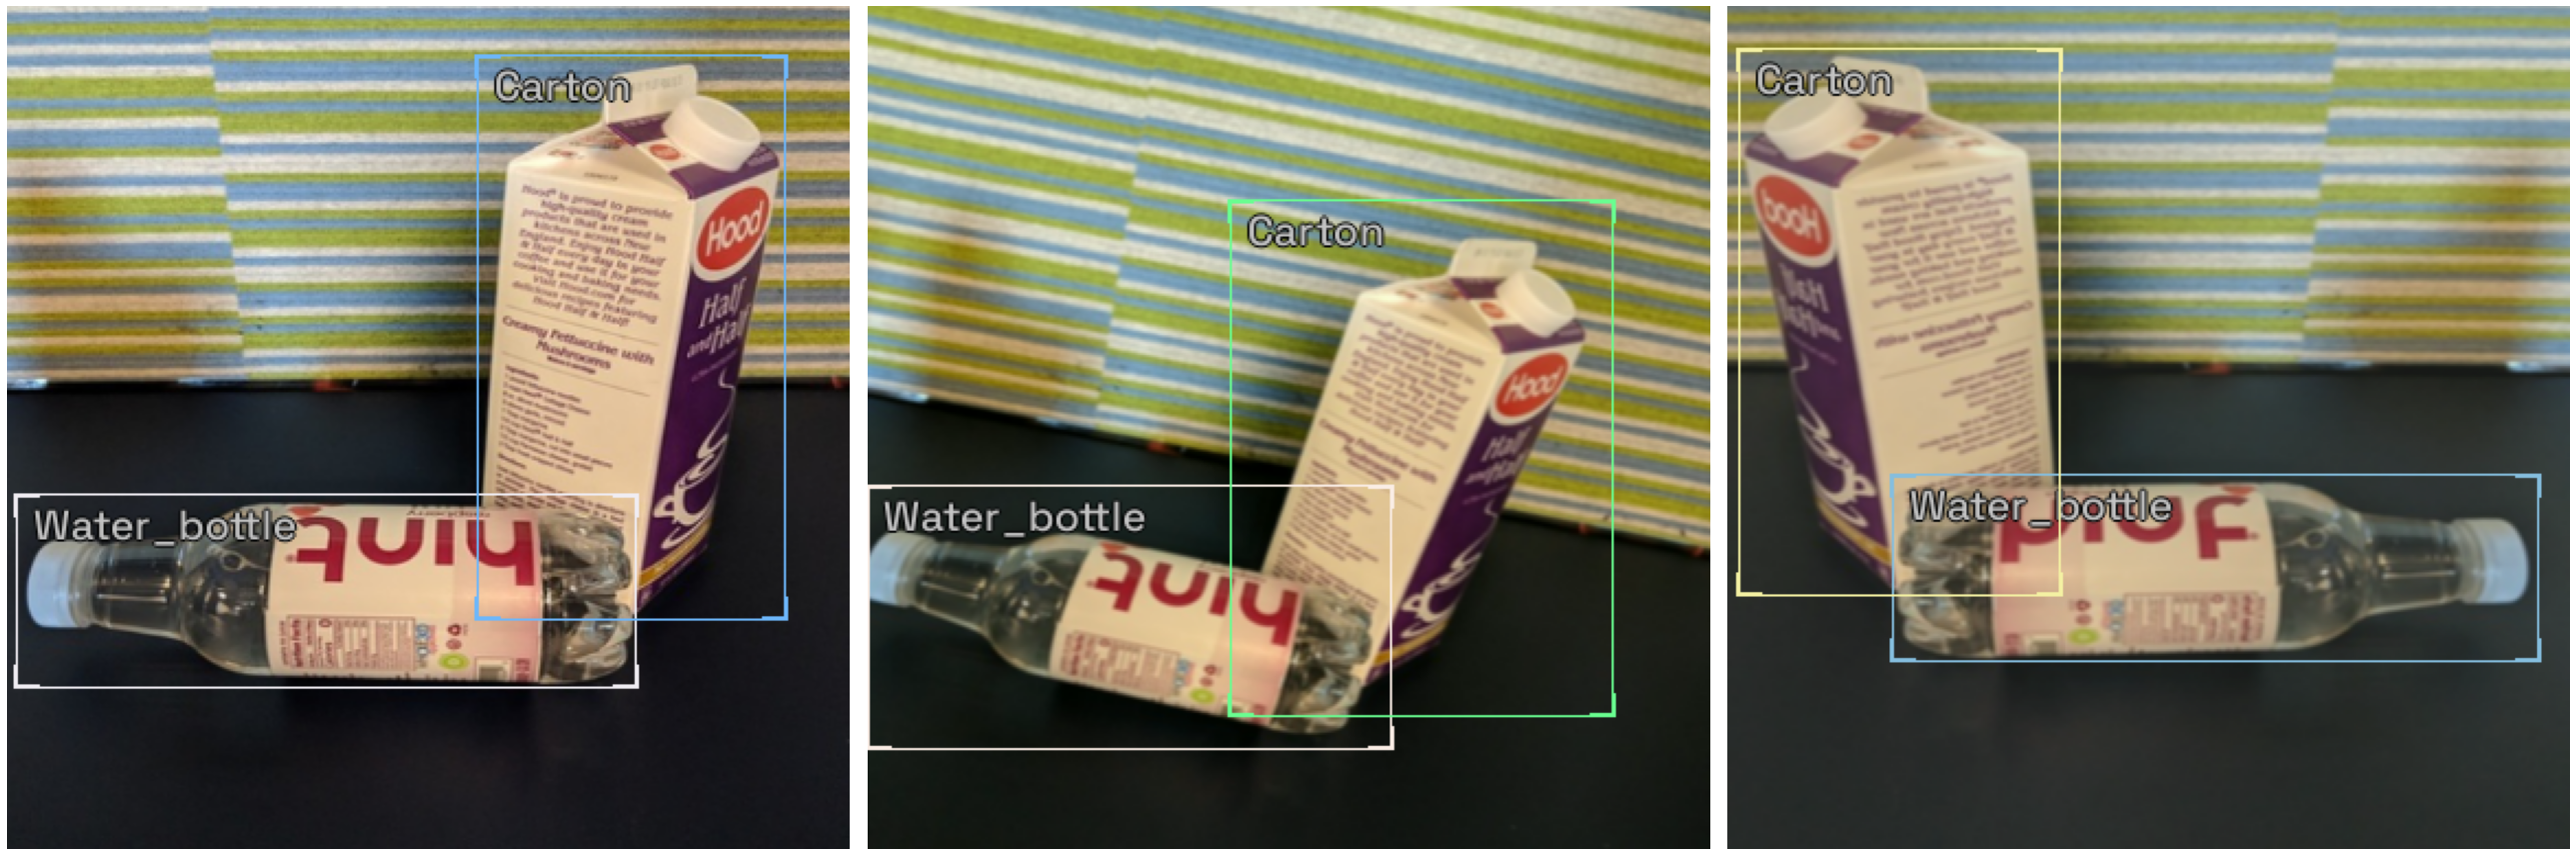

In [11]:
samples = [ds[0][0] for _ in range(3)]
show_samples(samples, ncols=3)

## DataLoader

In [ ]:
model_type.show_batch(first(dls[0]), ncols=4)

## Metrics

In [13]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

## Training

IceVision is an agnostic framework meaning it can be plugged to other DL framework such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  

You could also plug to oth DL framework using your own custom code.

### Training using fastai

In [14]:
learn = model_type.fastai.learner(dls=dls, model=model, metrics=metrics, cbs=SaveModelCallback(monitor='COCOMetric'))

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=0.00015848931798245758)

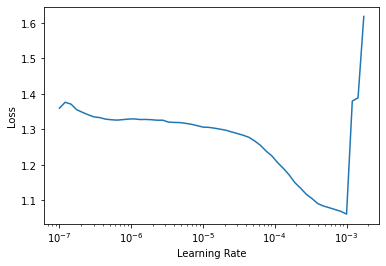

In [16]:
learn.lr_find()

### First Pass: First Training with the size = 384

In [17]:
learn.fine_tune(10, 1e-4, freeze_epochs=1)

Better model found at epoch 0 with COCOMetric value: 0.018334512022630832.


Better model found at epoch 0 with COCOMetric value: 0.07684290821192277.
Better model found at epoch 1 with COCOMetric value: 0.17224854342050785.
Better model found at epoch 2 with COCOMetric value: 0.31745342072333244.
Better model found at epoch 3 with COCOMetric value: 0.4092202239902201.
Better model found at epoch 4 with COCOMetric value: 0.5985001096045487.
Better model found at epoch 5 with COCOMetric value: 0.6494598763585641.
Better model found at epoch 6 with COCOMetric value: 0.6910227038257398.
Better model found at epoch 7 with COCOMetric value: 0.7076194302452169.
Better model found at epoch 8 with COCOMetric value: 0.735202499994352.
Better model found at epoch 9 with COCOMetric value: 0.7393958039433105.


## Restart resizing from here

## Subsequent Pass: Subsequent Training with the size = 512

In [29]:
# Second Pass (size = 512)
# presize = 640
# size = 512

# Third Pass (size = 640)
presize = 768
size = 640

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

ds, dls = get_dataloaders(model_type, [train_records, valid_records], [train_tfms, valid_tfms], batch_size=16, num_workers=2)

In [30]:
dls[0].dataset[0]

BaseRecord

common: 
	- Image size ImgSize(width=640, height=640)
	- Filepath: /root/.icevision/data/fridge/odFridgeObjects/images/112.jpg
	- Img: 640x640x3 <np.ndarray> Image
	- Record ID: 15
detection: 
	- BBoxes: [<BBox (xmin:98.14351388888991, ymin:376.93381905417573, xmax:576.7811863685447, ymax:620.2620189083259)>, <BBox (xmin:5.201505318565632, ymin:12.437821266274758, xmax:329.20034254651534, ymax:498.3316159707134)>]
	- Class Map: <ClassMap: {'background': 0, 'carton': 1, 'milk_bottle': 2, 'can': 3, 'water_bottle': 4}>
	- Labels: [4, 1]

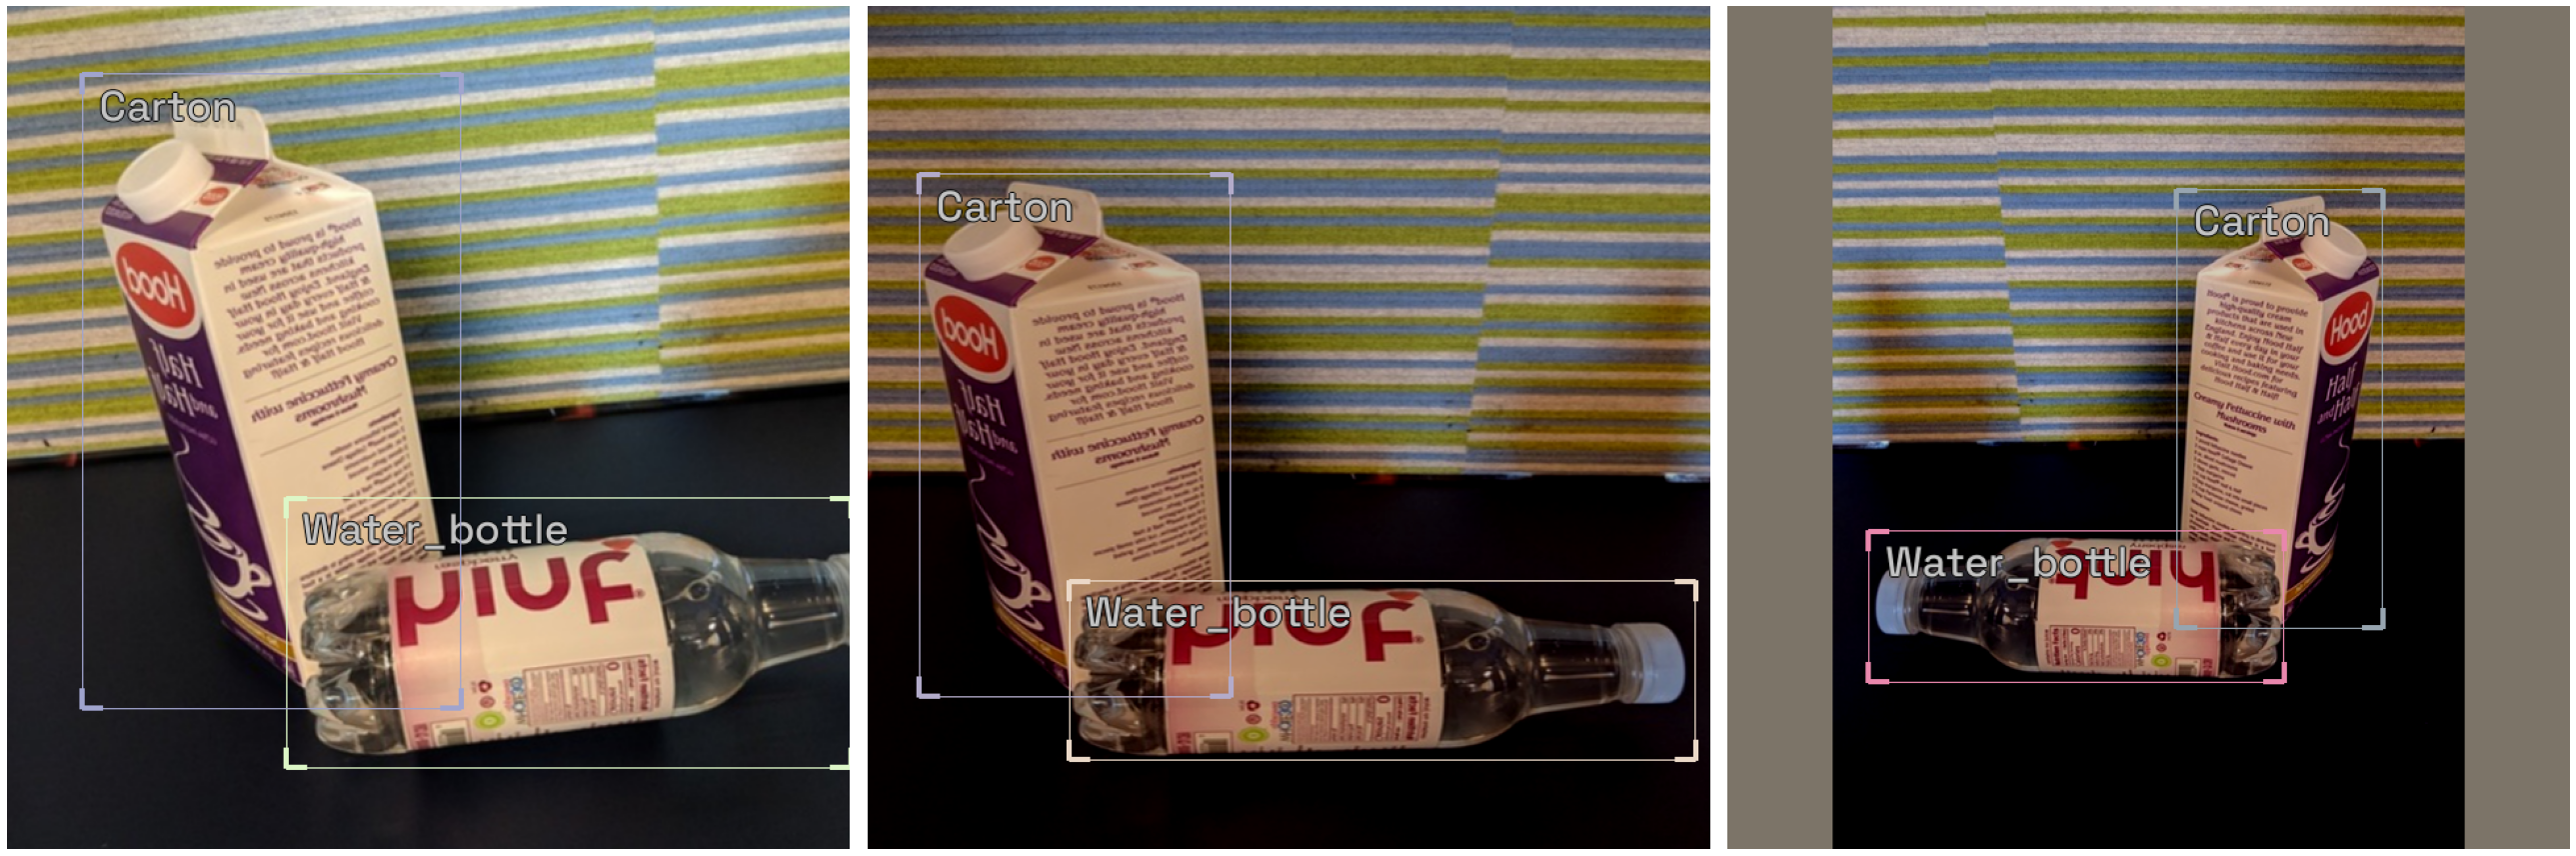

In [31]:
samples = [ds[0][0] for _ in range(3)]
show_samples(samples, ncols=3)

## Convert Pytorch DataLoaders to Fastai DataLoaders

In [32]:
from icevision.engines.fastai import *

fastai_dls = convert_dataloaders_to_fastai(dls=dls)

In [33]:
# Replace current dataloaders by the new ones (corresponding to the new size)
learn.dls = fastai_dls

In [34]:
print(fastai_dls[0])
print(learn.dls[0])

<icevision.engines.fastai.adapters.convert_dataloader_to_fastai.convert_dataloader_to_fastai.<locals>.FastaiDataLoaderWithCollate object at 0x7fe804b4b710>
<icevision.engines.fastai.adapters.convert_dataloader_to_fastai.convert_dataloader_to_fastai.<locals>.FastaiDataLoaderWithCollate object at 0x7fe804b4b710>


SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=9.12010818865383e-07)

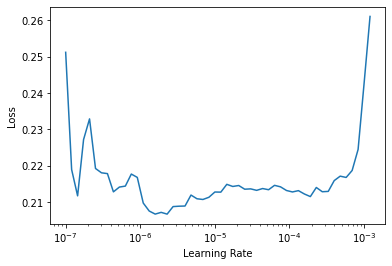

In [35]:
learn.lr_find()

In [36]:
learn.fine_tune(10, 1e-4, freeze_epochs=1)
# learn.fit_one_cycle(10, 2e-4)

Better model found at epoch 0 with COCOMetric value: 0.8570280948418122.


Better model found at epoch 0 with COCOMetric value: 0.8460132624669883.
Better model found at epoch 1 with COCOMetric value: 0.8651620055945506.
Better model found at epoch 5 with COCOMetric value: 0.8691152429678355.


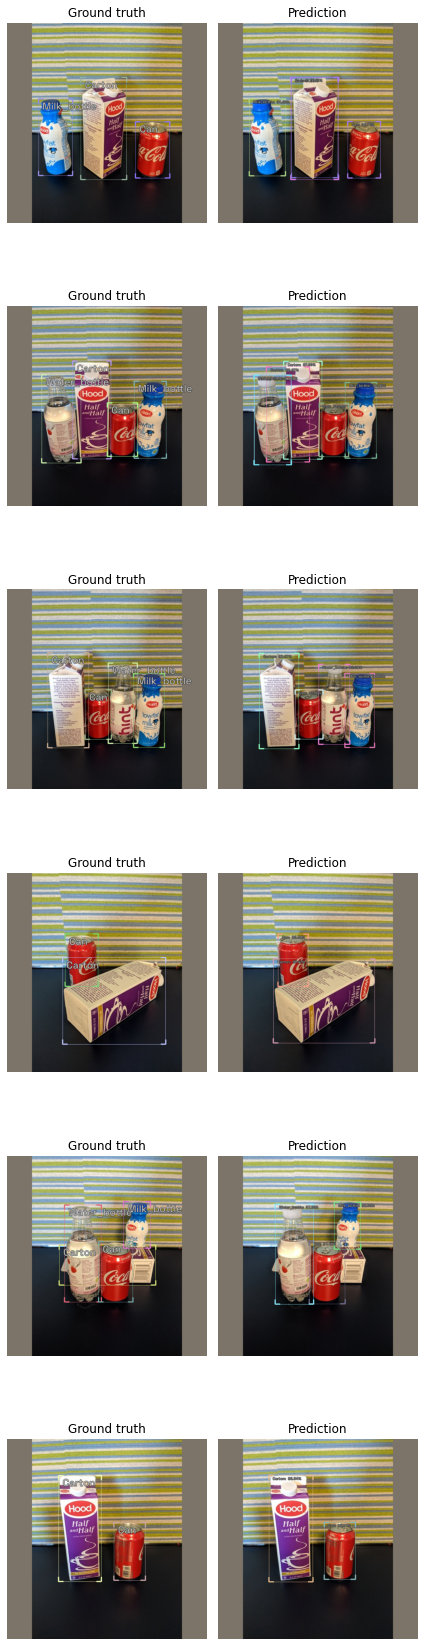

In [37]:
model_type.show_results(model, ds[1], detection_threshold=.5)

## Inference

### Predicting a batch of images

Instead of predicting a whole list of images at one, we can process small batch at the time: This option is more memory efficient. 


In [38]:
infer_dl = model_type.infer_dl(ds[1], batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/7 [00:00<?, ?it/s]

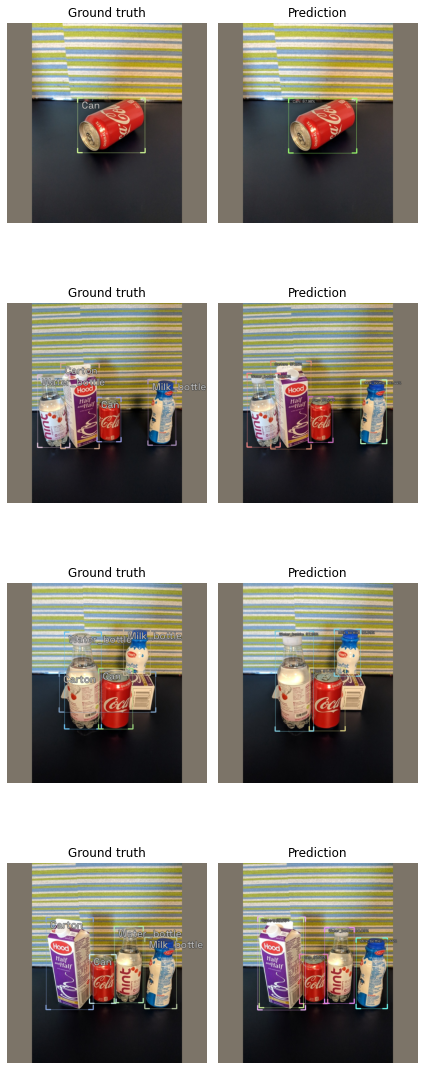

In [39]:
show_preds(preds=preds[:4])

## Training using Pytorch Lightning

You have to follow the same procedure as for the Fastai example. It is quite similar to the Fastai one except we don't need to convert dataloaders like in Fastai. PL dataloaders are just pytorch dataloaders.

```pyhon
# Create a model
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

# Create a trainer
trainer = pl.Trainer(max_epochs=10, gpus=1)

# First Pass  (size = 384)
# Transforms
presize = 512
size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

# Dataloaders
ds, dls = get_dataloaders(model_type, [train_records, valid_records], [train_tfms, valid_tfms], batch_size=16, num_workers=2)

First training
trainer.fit(light_model, dls[0], dls[1])

# Second Pass (size = 512)
presize = 640
size = 512

# Third Pass (size = 640)
# presize = 768
# size = 640

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])

# Dataloaders
ds, dls = get_dataloaders(model_type, [train_records, valid_records], [train_tfms, valid_tfms], batch_size=16, num_workers=2)

# Replace current dataloaders by the new ones (corresponding to the new size)
trainer.train_dataloader = dls[0]
trainer.valid_dataloader = dls[1]

# Subsequent training
trainer.fit(light_model, dls[0], dls[1])
```

## Saving Model on Google Drive

In [40]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

Mounted at /content/gdrive


In [41]:
torch.save(model.state_dict(), root_dir/'icevision/models/fridge/fridge_retinanet_prog_resizing_1.pth')

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).